# CSE 252A Computer Vision I Fall 2021 - Assignment 1

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle

# Surface Rendering

In this notebook we will be exploring different methods of approximating local reflectance of
objects in a scene and rendering surfaces using the surface normals and the masks from the provided pickle files, with various light sources, different materials, and using a number of reflectance models. For the sake of simplicity, multiple reflections of light rays, and occlusion of light rays due to object/scene can be ignored.

### Data

The surface normals and masks are to be loaded from the respective pickle files. For comparison, we will display the rendering results for both normals calculated from the original image and the diffuse components. 

We assume that the albedo map is uniform.

### Lambertian Reflectance

One of the simplest models available to render 3D objections with reflectance is the Lambertian model. This
model finds the apparent brightness to an observer using the direction of the light source $\mathbf{L}$ and the normal
vector on the surface of the object $\mathbf{N}$. The brightness intensity at a given point on an object’s surface, $\mathbf{I_d}$, with
a single light source is found using the following relationship:

$$\mathbf{I_d} = \mathbf{L} \cdot \mathbf{N} (I_l\mathbf{C})$$

where, $\mathbf{C}$ and $I_l$ are the the color and intensity of the light source respectively.

### Phong Reflectance

One major drawback of Lambertian reflectance is that it only considers the diffuse light in its calculation of
brightness intensity. One other major component to reflectance rendering is the specular component. The
specular reflectance is the component of light that is reflected in a single direction, as opposed to all directions,
which is the case in diffuse reflectance. One of the most used models to compute surface brightness with specular
components is the Phong reflectance model. This model combines ambient lighting, diffused reflectance as well
as specular reflectance to find the brightness on a surface. Phong shading also considers the material in the scene
which is characterized by four values: the ambient reflection constant ($k_a$), the diffuse reflection constant ($k_d$),
the specular reflection constant ($k_s$) and $\alpha$ the Phong constant, which is the ‘shininess’ of an object. Furthermore,
since the specular component produces ‘rays’, only some of which would be observed by a single observer, the
observer’s viewing direction ($\mathbf{V}$) must also be known. For some scene with known material parameters with $M$
light sources the light intensity $\mathbf{I}_{phong}$ on a surface with normal vector $\mathbf{N}$ seen from viewing direction $\mathbf{V}$ can be
computed by:

$$\mathbf{I}_{phong} = k_{a}\mathbf{I}_{a} + \sum_{m\in M}\left\{k_d(\mathbf{L}_{m}\cdot\mathbf{N})\mathbf{I}_{m,d} + k_{s}(\mathbf{R}_{m}\cdot\mathbf{V})^{\alpha}\mathbf{I}_{m,s}\right\}\text{,}$$

$$\mathbf{R}_{m} = 2\mathbf{N}(\mathbf{L}_{m}\cdot\mathbf{N}) - \mathbf{L}_{m}\text{,}$$

where $\mathbf{I}_{a}$, is the color and intensity of the ambient lighting, $\mathbf{I}_{m,d}$ and $\mathbf{I}_{m,s}$ are the color values for the diffuse and
specular light of the $m$th light source.

### Rendering


1. `lambertian()` calculates the Lambertian light intensity given the light direction $\mathbf{L}$ with color and intensity $\mathbf{C}$ and $I_l = 1$, and normal vector $\mathbf{N}$.

1. `phong()` calculates the Phong light intensity given the material constants $(k_a, k_d, k_s, \alpha)$, $\mathbf{V} = (0, 0, 1)^\top$, $\mathbf{N}$ and some number of $M$ light sources.


Table 1: Light Sources

| $m$ | Location | Color (RGB)  |
| - | ----------- | ----- |
| 1 | $(-\tfrac{1}{2},\tfrac{1}{2},\tfrac{1}{2})^{\top}$ | $(1,1,1)$ |
| 2 | $(1,0,0)^{\top}$     | $(1,.5,1)$ |

Table 2: Material Coefficients

| Mat. | $k_a$ | $k_d$ | $k_s$ | $\alpha$ |
| - | -------- | ----- | ----- | -------- |
| 1 | $0$ | $0.1$ | $0.5$ | $5$ |
| 2 | $0$ | $0.5$ | $0.1$ | $5$ |
| 3 | $0$ | $0.5$ | $0.5$ | $10$ |

### Loading pickle files and plotting the normals
The pickle file normals.pickle is a list consisting of 4 numpy matrices which are    
1) Normal Vectors for the sphere with specularities removed (Diffuse component)  
2) Normal Vector for the sphere    
3) Normal Vectors for the pear with specularities removed (Diffuse component)  
4) Normal vectors for the pear  

In [3]:
def plot_normals(diffuse_normals, original_normals):
    # Stride in the plot, you may want to adjust it to different images
    stride = 5
    
    normalss = diffuse_normals
    normalss1 = original_normals
    
#     print("Normals:")
    print("Diffuse")
    # showing normals as three separate channels
    figure = plt.figure()
    ax1 = figure.add_subplot(131)
    ax1.imshow(normalss[..., 0])
    ax2 = figure.add_subplot(132)
    ax2.imshow(normalss[..., 1])
    ax3 = figure.add_subplot(133)
    ax3.imshow(normalss[..., 2])
    plt.show()
    print("Original")
    figure = plt.figure()
    ax1 = figure.add_subplot(131)
    ax1.imshow(normalss1[..., 0])
    ax2 = figure.add_subplot(132)
    ax2.imshow(normalss1[..., 1])
    ax3 = figure.add_subplot(133)
    ax3.imshow(normalss1[..., 2])
    plt.show()

Normals for Sphere
Diffuse


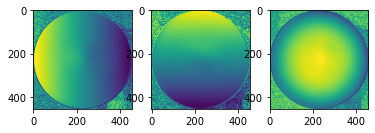

Original


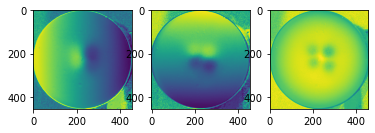

In [24]:
#Plot the normals for the sphere and pear for both the normal and diffuse components.
#1 : Load the different normals
# LOAD HERE
normals = np.load("normals.pkl", allow_pickle=True)

#2 : Plot the normals using plot_normals
#What do you observe? What are the differences between the diffuse component and the original images shown?

print("Normals for Sphere")
plot_normals(normals[0], normals[1])

# print("\nNormals for Pear")
# plot_normals(normals[2], normals[3])

#PLOT HERE

### Lambertian model

In [25]:
def normalize(img):
    maxi = img.max()
    mini = img.min()
    return (img - mini)/(maxi-mini)

In [26]:
def lambertian(normals, lights, color, intensity, mask):
    '''Your implementation'''
    
    # normal vector dot light direction
    dotP=np.zeros((normals.shape[0], normals.shape[1],1))
    
    dotP = normals.dot(lights) # vectorised

    # Remove negatives intensities
    dotP[dotP<0]=0
    
    # Apply Mask
    dotP = dotP*mask.reshape(mask.shape[0], mask.shape[1], 1)
    
    # Multiply by colour of light to get RGB image
    image = np.matmul(dotP, color*intensity)
    
    # return normalized image
    return normalize(image)

### Lambertian model on Sphere and Pear

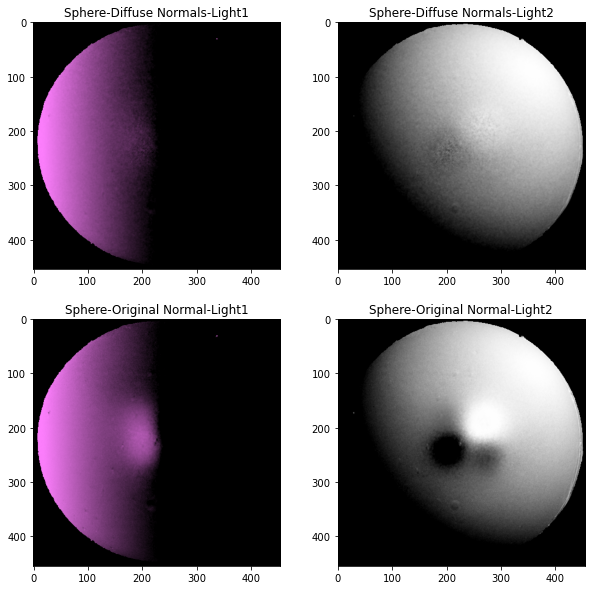

In [27]:
# Load the masks for the sphere and pear
# LOAD HERE

masks = np.load("masks.pkl", allow_pickle=True)

# Output the rendering results for Sphere
dirn1 = np.array([[1.0],[0],[0]])
color1 = np.array([[1,.5,1]])
dirn2 = np.array([[-1.0/2],[1.0/2],[1.0/2]])
color2 = np.array([[1,1,1]])
#Display the rendering results for sphere for both diffuse and for both the light sources
figure = plt.figure(figsize=(10,10))

ax1 = figure.add_subplot(221)
img1 = lambertian(normals[0], dirn1, color1, 1, masks[0]) 
ax1.imshow(normalize(img1))
ax1.title.set_text("Sphere-Diffuse Normals-Light1")

ax2 = figure.add_subplot(222)
img2 = lambertian(normals[0], dirn2, color2, 1, masks[0]) 
ax2.imshow(normalize(img2))
ax2.title.set_text("Sphere-Diffuse Normals-Light2")

ax3 = figure.add_subplot(223)
img3 = lambertian(normals[1], dirn1, color1, 1, masks[0]) 
ax3.imshow(normalize(img3))
ax3.title.set_text("Sphere-Original Normal-Light1")

ax4 = figure.add_subplot(224)
img4 = lambertian(normals[1], dirn2, color2, 1, masks[0]) 
ax4.imshow(normalize(img4))
ax4.title.set_text("Sphere-Original Normal-Light2")


# # Output the rendering results for Pear
# dirn1 = np.array([[1.0],[0],[0]])
# color1 = np.array([[1,.5,1]])
# dirn2 = np.array([[-1.0/2],[1.0/2],[1.0/2]])
# color2 = np.array([[1,1,1]])

# #Display the rendering results for pear for both diffuse and for both the light sources
# figure = plt.figure(figsize=(10,10))

# ax1 = figure.add_subplot(221)
# img1 = lambertian(normals[2], dirn1, color1, 1, masks[1]) 
# ax1.imshow(normalize(img1))
# ax1.title.set_text("Pear-Diffuse Normals-Light1")

# ax2 = figure.add_subplot(222)
# img2 = lambertian(normals[2], dirn2, color2, 1, masks[1]) 
# ax2.imshow(normalize(img2))
# ax2.title.set_text("Pear-Diffuse Normals-Light2")

# ax3 = figure.add_subplot(223)
# img3 = lambertian(normals[3], dirn1, color1, 1, masks[1]) 
# ax3.imshow(normalize(img3))
# ax3.title.set_text("Pear-Original Normals-Light1")

# ax4 = figure.add_subplot(224)
# img4 = lambertian(normals[3], dirn2, color2, 1, masks[1]) 
# ax4.imshow(normalize(img4))
# ax4.title.set_text("Pear-Original Normals-Light2")

### Phong model [8 pts]

In [28]:
def phong(normals, lights, colors, material, view, mask):
    '''Your implementation'''
    
    # The ka term is zero and thus the lightening due to ambient light is ignored and image is initialised to with all pixel values as 0 
    image = np.zeros_like(normals)
    
    for light,color in zip(lights,colors):
        
        # Calculate the first term
        term1 = normals.dot(light)
        # remove negative intensities
        term1[term1<0]=0
        
        # apply mask
        term1=term1*mask.reshape(mask.shape[0], mask.shape[1], 1)
        
        # Multiply by colour of light to get RGB image
        # Multiply by constant kd
        term1 = material[0]*np.matmul(term1, color)
        
        
        # Calculate the second term
        Rm = 2*normals*(normals.dot(light))-light.reshape(-1)
        
        term2 = Rm.dot(view)
        term2 = np.power(term2, material[2])
        
        # remove negative intensities
        term2[term2<0]=0
        
        # apply mask
        term2=term2*mask.reshape(mask.shape[0], mask.shape[1], 1)
        
        # Multiply by colour of light to get RGB image
        # Multiply by constant ks
        term2 = material[1]*np.matmul(term2, color)
        
        image+=(term1+term2)
        
    return (normalize(image))

With the function completed, plot the rendering results for the sphere and pear (both diffuse and original compnents) for all the materials and light sources and also with the combination of both the light sources.

In [29]:
# Output the rendering results for sphere
view =  np.array([[0],[0],[1]])
material = np.array([[0.1,0.5,5],[0.5,0.1,5],[0.5,0.5,10]])
lightcol1 =  np.array([[-1.0/2,1],[1.0/2,1],[1.0/2,1]])
lightcol2 = np.array([[1,1],[0,0.5],[0,1]])
#Display rendered results for sphere for all materials and light sources and combination of light sources

### Plots for Difuse Normals of Sphere

Plots for Difuse Normals of Sphere


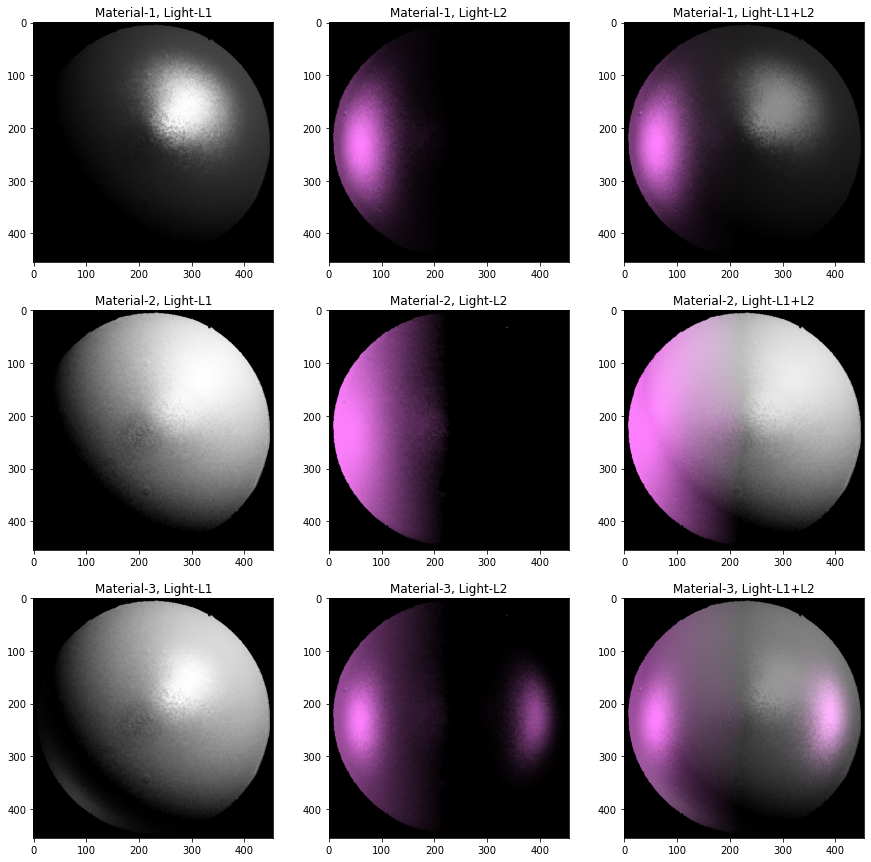

In [30]:
print("Plots for Difuse Normals of Sphere")
# Start with one
fig = plt.figure(1, figsize=(15,15))
i=1
lights_text={0:"L1", 1:"L2", 2:"L1+L2"}

for material_ind,material_ in enumerate(material):
    for lc_ind, lc in enumerate(((lightcol1,),(lightcol2,),(lightcol1,lightcol2))):
        
        if len(lc)==1:
            light1 = np.asarray([lc[0][0][0],lc[0][1][0],lc[0][2][0]]).reshape(3,1)
            col1 = np.asarray([lc[0][0][1],lc[0][1][1],lc[0][2][1]]).reshape(1,3)
            spherePhong = phong(normals[0], (light1,), (col1,), material_, view, masks[0])
            
        else:
            light1 = np.asarray([lc[0][0][0],lc[0][1][0],lc[0][2][0]]).reshape(3,1)
            col1 = np.asarray([lc[0][0][1],lc[0][1][1],lc[0][2][1]]).reshape(1,3)
            
            light2 = np.asarray([lc[1][0][0],lc[1][1][0],lc[1][2][0]]).reshape(3,1)
            col2 = np.asarray([lc[1][0][1],lc[1][1][1],lc[1][2][1]]).reshape(1,3)
            
            spherePhong = phong(normals[0], (light1, light2), (col1, col2), material_, view, masks[0])
        
        ax = fig.add_subplot(3,3,i)
        i+=1
        ax.imshow(spherePhong)
        ax.title.set_text("Material-{}, Light-{}".format(material_ind+1, lights_text[lc_ind]))

### Plots for Normals with Spectral information of Sphere

Plots for Original Normals(with Spectral Information) of Sphere


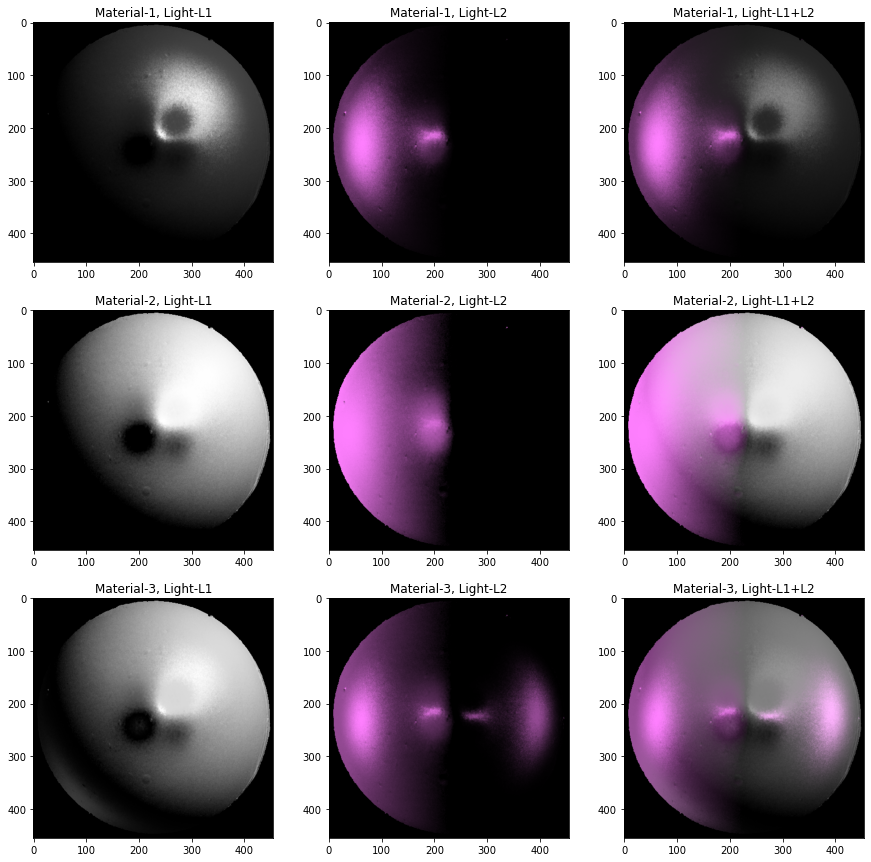

In [31]:
print("Plots for Original Normals(with Spectral Information) of Sphere")
# Start with one
fig = plt.figure(1, figsize=(15,15))
i=1
for material_ind,material_ in enumerate(material):
    for lc_ind, lc in enumerate(((lightcol1,),(lightcol2,),(lightcol1,lightcol2))):
        
        if len(lc)==1:
            light1 = np.asarray([lc[0][0][0],lc[0][1][0],lc[0][2][0]]).reshape(3,1)
            col1 = np.asarray([lc[0][0][1],lc[0][1][1],lc[0][2][1]]).reshape(1,3)
            spherePhong = phong(normals[1], (light1,), (col1,), material_, view, masks[0])
            
        else:
            light1 = np.asarray([lc[0][0][0],lc[0][1][0],lc[0][2][0]]).reshape(3,1)
            col1 = np.asarray([lc[0][0][1],lc[0][1][1],lc[0][2][1]]).reshape(1,3)
            
            light2 = np.asarray([lc[1][0][0],lc[1][1][0],lc[1][2][0]]).reshape(3,1)
            col2 = np.asarray([lc[1][0][1],lc[1][1][1],lc[1][2][1]]).reshape(1,3)
            
            spherePhong = phong(normals[1], (light1, light2), (col1, col2), material_, view, masks[0])
        
        ax = fig.add_subplot(3,3,i)
        i+=1
        ax.imshow(spherePhong)
        ax.title.set_text("Material-{}, Light-{}".format(material_ind+1, lights_text[lc_ind]))

### Plots for Difuse Normals of Pear

Plots for Difuse Normals of Pear


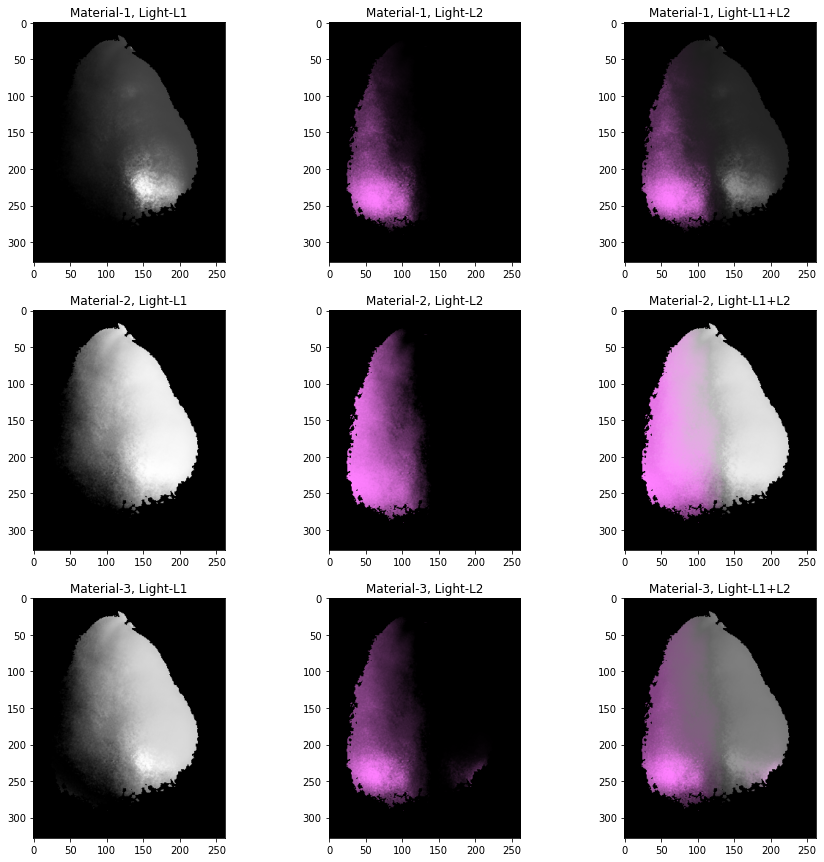

In [33]:
print("Plots for Difuse Normals of Pear")
# Start with one
fig = plt.figure(1, figsize=(15,15))
i=1
for material_ind,material_ in enumerate(material):
    for lc_ind, lc in enumerate(((lightcol1,),(lightcol2,),(lightcol1,lightcol2))):
        
        if len(lc)==1:
            light1 = np.asarray([lc[0][0][0],lc[0][1][0],lc[0][2][0]]).reshape(3,1)
            col1 = np.asarray([lc[0][0][1],lc[0][1][1],lc[0][2][1]]).reshape(1,3)
            PearPhong = phong(normals[2], (light1,), (col1,), material_, view, masks[1])
            
        else:
            light1 = np.asarray([lc[0][0][0],lc[0][1][0],lc[0][2][0]]).reshape(3,1)
            col1 = np.asarray([lc[0][0][1],lc[0][1][1],lc[0][2][1]]).reshape(1,3)
            
            light2 = np.asarray([lc[1][0][0],lc[1][1][0],lc[1][2][0]]).reshape(3,1)
            col2 = np.asarray([lc[1][0][1],lc[1][1][1],lc[1][2][1]]).reshape(1,3)
            
            PearPhong = phong(normals[2], (light1, light2), (col1, col2), material_, view, masks[1])
        
        ax = fig.add_subplot(3,3,i)
        i+=1
        ax.imshow(PearPhong)
        ax.title.set_text("Material-{}, Light-{}".format(material_ind+1, lights_text[lc_ind]))

### Plots for Normals with Spectral information of Pear

Plots for Normals with Spectral information of Pear


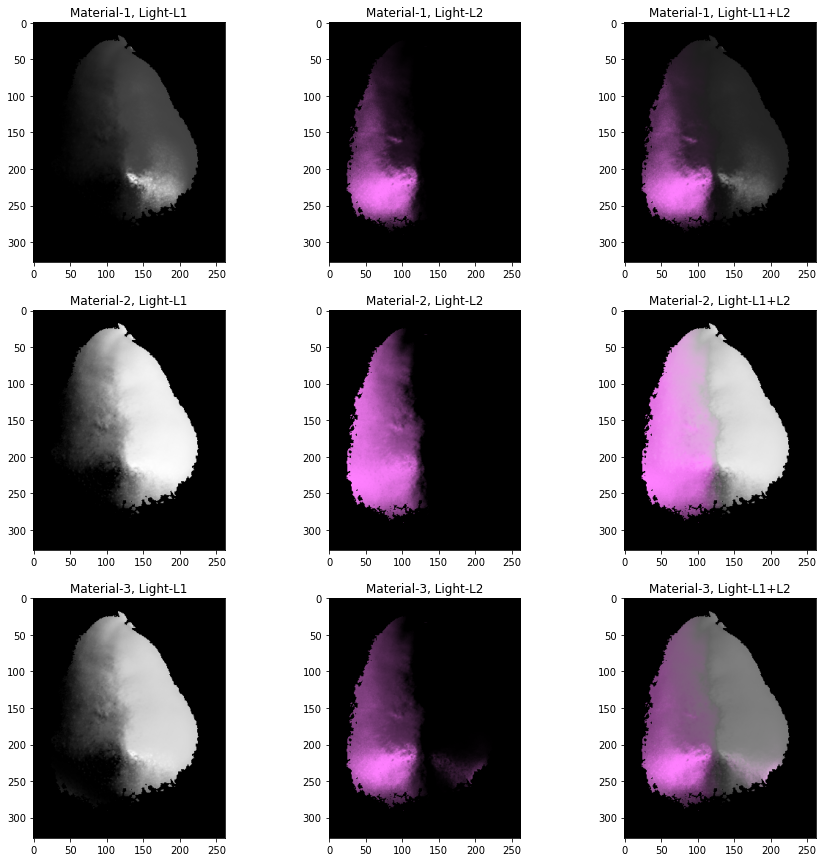

In [34]:
print("Plots for Normals with Spectral information of Pear")
# Start with one
fig = plt.figure(1, figsize=(15,15))
i=1
for material_ind,material_ in enumerate(material):
    for lc_ind, lc in enumerate(((lightcol1,),(lightcol2,),(lightcol1,lightcol2))):
        
        if len(lc)==1:
            light1 = np.asarray([lc[0][0][0],lc[0][1][0],lc[0][2][0]]).reshape(3,1)
            col1 = np.asarray([lc[0][0][1],lc[0][1][1],lc[0][2][1]]).reshape(1,3)
            PearPhong = phong(normals[3], (light1,), (col1,), material_, view, masks[1])
            
        else:
            light1 = np.asarray([lc[0][0][0],lc[0][1][0],lc[0][2][0]]).reshape(3,1)
            col1 = np.asarray([lc[0][0][1],lc[0][1][1],lc[0][2][1]]).reshape(1,3)
            
            light2 = np.asarray([lc[1][0][0],lc[1][1][0],lc[1][2][0]]).reshape(3,1)
            col2 = np.asarray([lc[1][0][1],lc[1][1][1],lc[1][2][1]]).reshape(1,3)
            
            PearPhong = phong(normals[3], (light1, light2), (col1, col2), material_, view, masks[1])
        
        ax = fig.add_subplot(3,3,i)
        i+=1
        ax.imshow(PearPhong)
        ax.title.set_text("Material-{}, Light-{}".format(material_ind+1, lights_text[lc_ind]))

## Specularity Removal [6 pts]

We implement the specularity removal technique described in *Beyond Lambert: Reconstructing Specular Surfaces Using Color* (by Mallick, Zickler, Kriegman, and Belhumeur; CVPR 2005).

Note:All the data for this part is found in `specular_sphere.pickle` and `specular_pear.pickle`.

In [35]:
def get_rot_mat(rot_v, unit=None):
    '''
    Takes a vector and returns the rotation matrix required to align the
    unit vector(2nd arg) to it.
    '''
    if unit is None:
        unit = [1.0, 0.0, 0.0]
    
    rot_v = rot_v/np.linalg.norm(rot_v)
    uvw = np.cross(rot_v, unit) # axis of rotation

    rcos = np.dot(rot_v, unit) # cos by dot product
    rsin = np.linalg.norm(uvw) # sin by magnitude of cross product

    # normalize and unpack axis
    if not np.isclose(rsin, 0):
        uvw = uvw/rsin
    u, v, w = uvw

    # compute rotation matrix 
    R = (
        rcos * np.eye(3) +
        rsin * np.array([
            [ 0, -w,  v],
            [ w,  0, -u],
            [-v,  u,  0]
        ]) +
        (1.0 - rcos) * uvw[:,None] * uvw[None,:]
    )
    return R

## This function implementation assumes that the I_rgb image is normalised
# One can add a line I_rgb = normalize(I_rgb) 
def RGBToSUV(I_rgb, rot_vec):
    '''
    Your implementation which takes an RGB image and a vector encoding
    the orientation of the S channel w.r.t. to RGB.
    '''

    """ ==========
    YOUR CODE HERE
    ========== """

    # Initialise I_suv
    I_suv = np.zeros_like(I_rgb)
    
    # normalize input image
    # I_rgb = I_rgb
    # Get the rotation matrix
    R = get_rot_mat(rot_vec)
    
    # Rotate the original image so that the S channel is aligned with the first axis given by R
    #(which represents the colour of light)
    for i in range(I_rgb.shape[0]):
        for j in range(I_rgb.shape[1]):
            I_suv[i][j]=R.dot(I_rgb[i][j])
        
    # Spectral Channel
    S = I_suv[:,:,0]
    # Diffuse Channel
    G = (I_suv[:,:,1]**2+I_suv[:,:,2]**2)**0.5
    return S, G

### Specularity Removal for Sphere and Pear

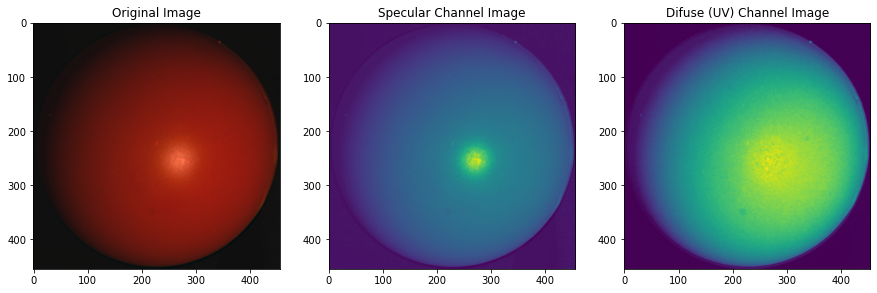

In [36]:
pickle_in = open("specular_sphere.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")
masks = np.load("masks.pkl", allow_pickle=True)
# sample input
S, G = RGBToSUV(data["im1"], np.hstack((data["c"][0][0],
                                        data["c"][1][0],
                                        data["c"][2][0])))

figure = plt.figure(figsize=(15,10))
ax1 = figure.add_subplot(131)
ax1.imshow(normalize(data["im1"]))
ax1.title.set_text("Original Image")
ax2 = figure.add_subplot(132)
ax2.imshow(S)
ax2.title.set_text("Specular Channel Image")
ax3 = figure.add_subplot(133)
ax3.imshow(G)
ax3.title.set_text("Difuse (UV) Channel Image")
plt.show()

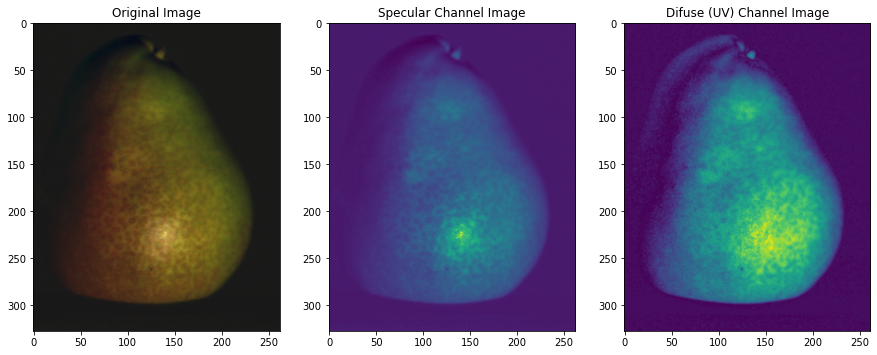

In [37]:
pickle_in = open("specular_pear.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

# sample input
S, G = RGBToSUV(normalize(data["im1"]), np.hstack((data["c"][0][0],
                                        data["c"][1][0],
                                        data["c"][2][0])))

figure = plt.figure(figsize=(15,10))
ax1 = figure.add_subplot(131)
ax1.imshow(normalize(data["im1"]))
ax1.title.set_text("Original Image")
ax2 = figure.add_subplot(132)
ax2.imshow(S)
ax2.title.set_text("Specular Channel Image")
ax3 = figure.add_subplot(133)
ax3.imshow(G)
ax3.title.set_text("Difuse (UV) Channel Image")
plt.show()